# Covid19 evolution

Data source: 

- covid data: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
- population by country: https://www.worldometers.info/world-population/population-by-country/

In [1]:
from pathlib import Path

import pandas as pd
import requests
from bs4 import BeautifulSoup

from plot import plot_countries_evolution

In [2]:
URLS = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv',
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv']
POP_URL = 'https://www.worldometers.info/world-population/population-by-country/'
files = [url.split('/')[-1] for url in URLS]

In [3]:
# Download the updated files.
for url, file in zip(URLS, files):
    print(f'Retrieving {url}')
    with open(Path('.').joinpath(file), 'wb') as f:
        f.write(requests.get(url).content)

Retrieving https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
Retrieving https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv
Retrieving https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv


In [4]:
# Create the DataFrames for each category ('Confirmed', 'Deaths', 'Recovered').
data = {file.split('-')[-1].split('.')[0]: 
        (pd.read_csv(Path('.')
         .joinpath(file))
         .rename({'Province/State': 'State', 'Country/Region': 'Country'}, axis='columns')
         .set_index(['State', 'Country'])
         .drop(['Lat', 'Long'], axis='columns')
         )
        for file in files}

In [5]:
# Recover the population of the countries, webscraping from `POP_URL`.
# Don't recreate if already exists.
country_path = Path('.').joinpath('country.parquet')
if country_path.is_file():
    df_country = pd.read_parquet(country_path)
else:
    response = requests.get(POP_URL)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table')
    # Recover the header of the table.
    header = [e.text.strip() for e in table.find_all('th')[1:]]
    rows = table.find('tbody').find_all('tr')

    data_countries = []
    for row in rows:
        data_countries.append([e.text.strip() for e in row.find_all('td')[1:]])

    df_country = (pd.DataFrame(data_countries, columns=header)
                  .rename({'Country (or dependency)': 'Country', 
                           'Population (2020)': 'Population'}, 
                          axis='columns')
                  .set_index('Country')
                  )
    df_country.to_parquet(country_path)

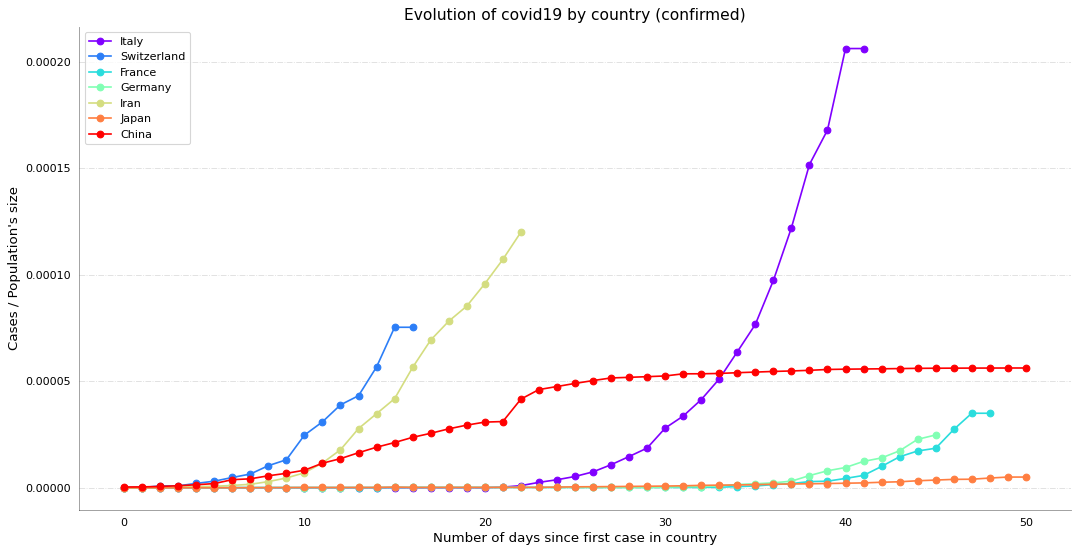

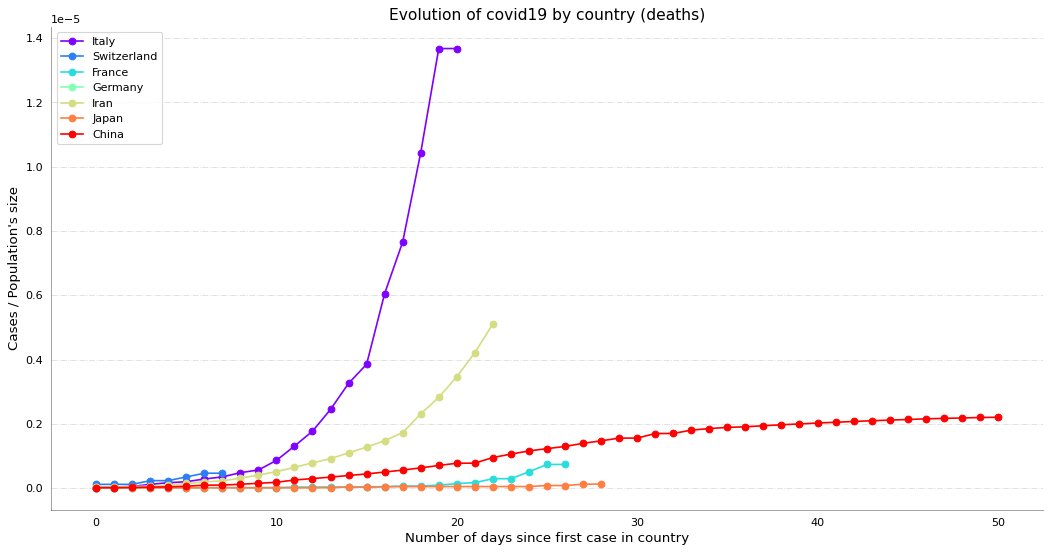

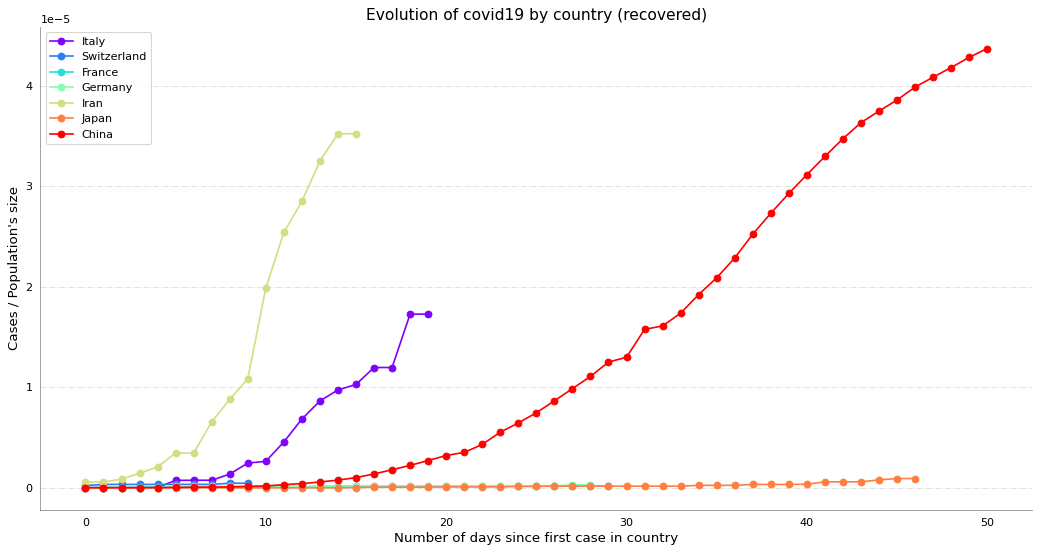

In [6]:
for cases in data.keys():
    plot_countries_evolution(data, df_country, 'Italy', 'Switzerland', 'France', 
                             'Germany', 'Iran', 'Japan', 'China',
                             cases=cases, relatif=True)

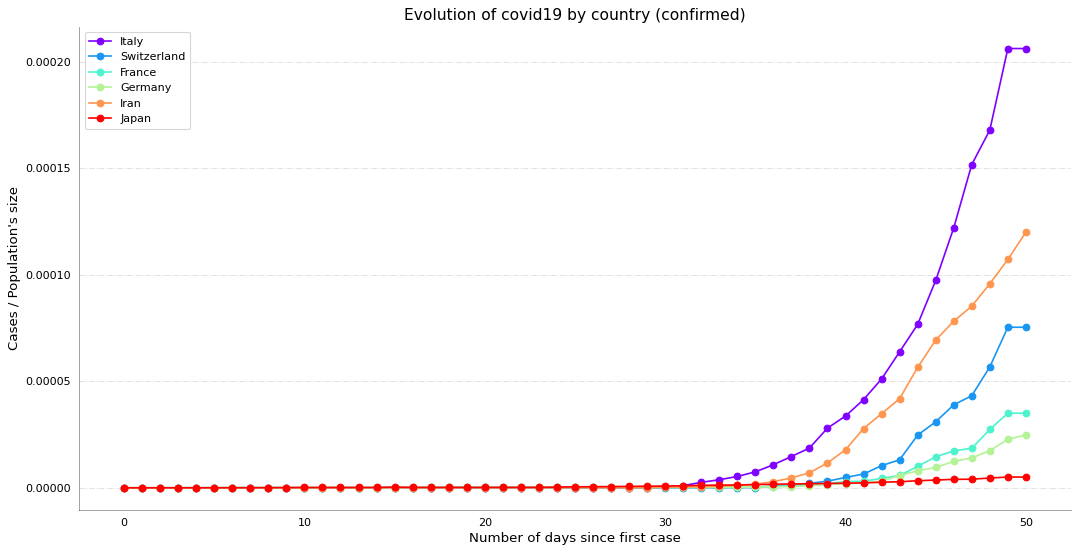

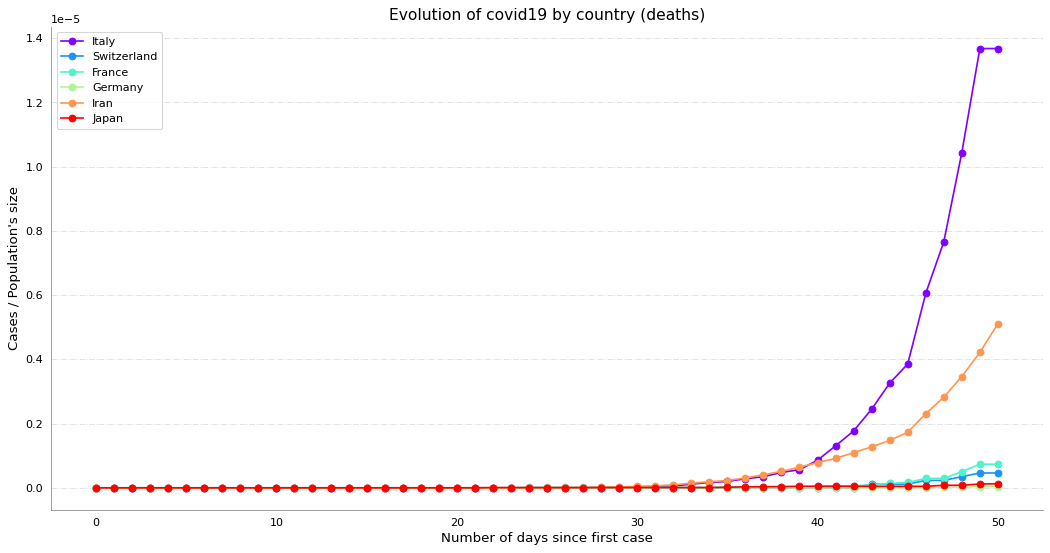

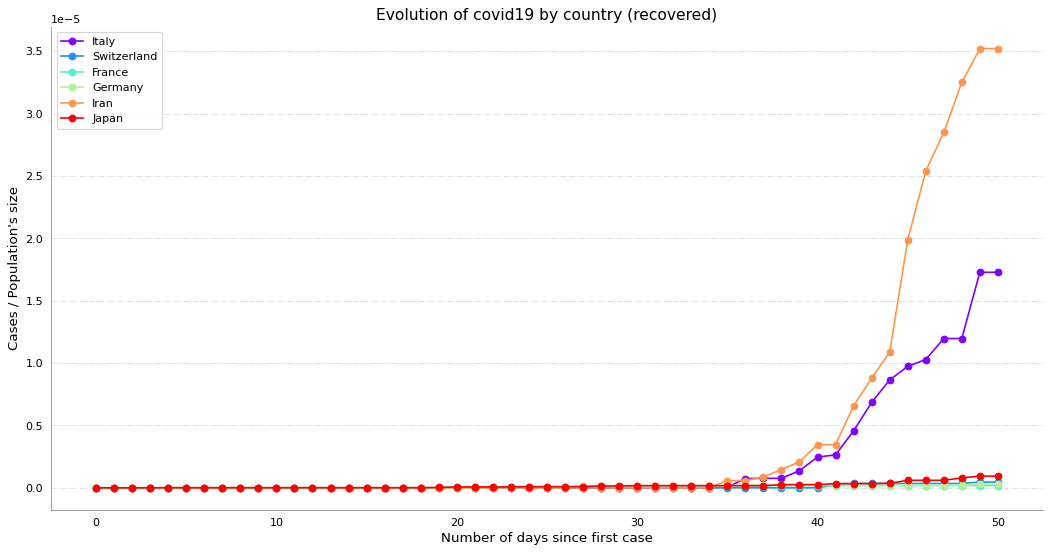

In [7]:
for cases in data.keys():
    plot_countries_evolution(data, df_country, 'Italy', 'Switzerland', 'France', 
                             'Germany', 'Iran', 'Japan', 
                             cases=cases, relatif=False)